In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import networkx as nx

In [2]:
data = pd.read_csv("../data/preprocessed_data.csv")

In [3]:
male_data = data[data["sex"] == "m"]
female_data = data[data["sex"] == "f"]

In [4]:
# Clustering males and females
def cluster_users(males_features, females_features, num_clusters=10):
    """
    Clusters both males and females separately and returns the cluster labels for each.
    """
    # Clustering the males
    males_kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    males_clusters = males_kmeans.fit_predict(males_features)
    
    # Clustering the females
    females_kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    females_clusters = females_kmeans.fit_predict(females_features)
    
    return males_clusters, females_clusters, males_kmeans, females_kmeans

# Function to find the N nearest males for a given female user
def find_nearest_males(female_idx, females_features, males_features, females_clusters, males_clusters, N=100):
    """
    Given the index of a female, returns the N nearest males from the same cluster.
    """
    # Get the cluster of the given female
    female_cluster = females_clusters[female_idx]
    
    # Find all males in the same cluster
    males_in_same_cluster = np.where(males_clusters == female_cluster)[0]
    
    # Get the feature vector of the female
    female_features = females_features[female_idx].reshape(1, -1)
    
    # Calculate the cosine similarity between the female and each male in the same cluster
    similarities = []
    for male_idx in males_in_same_cluster:
        male_features = males_features[male_idx].reshape(1, -1)
        similarity = cosine_similarity(female_features, male_features)[0][0]
        similarities.append((male_idx, similarity))
    
    # Sort by similarity and return the top N males
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_n_males = [male_idx for male_idx, _ in similarities[:N]]
    
    return top_n_males

In [5]:
with open("../data/females_features", "rb") as f:
    females_features = pickle.load(f)

with open("../data/males_features", "rb") as f:
    males_features = pickle.load(f)

females_features.shape, males_features.shape    

((20533, 261), (31073, 261))

In [6]:
N: int = 500

# Cluster males and females separately
males_clusters, females_clusters, males_kmeans, females_kmeans = cluster_users(males_features, females_features, num_clusters=10)

# Let's say you want to find the top 5 nearest males for a female at index 10
female_idx = 238
top_N_males = find_nearest_males(female_idx, females_features, males_features, females_clusters, males_clusters, N=N)

### Let's have a brief glance at the result

In [7]:
female_data.iloc[female_idx]

age                                                           37
status                                                    single
sex                                                            f
orientation                                             straight
body_type                                              endomorph
drinks                                                  socially
education                                        College or more
height                                                     173.0
job                                            medicine / health
location                                     oakland, california
religion                                             agnosticism
smokes                                                        no
essay0         i am a leader, reader and eater. i'm the glue ...
essay1         volunteering, i recruit people to do it for wo...
essay2         planning a party and executing it. i know more...
essay3         my laugh, 

In [8]:
male_data.iloc[top_N_males]

,age,status,sex,orientation,body_type,drinks,education,height,job,location,...,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,likes_dogs,likes_cats
15067,50,single,m,straight,endomorph,socially,College or more,183.0,other,"oakland, california",...,"showering attention, making people laugh, play...",my sense of humor and ability to put people at...,"food: sushi music: jazz fusion, especially ret...","my friends, my cat, my computer, my drumkit/mu...",nothing in particular. i don't obsess over any...,rehearsing with the band in our studio in west...,i derive great satisfaction in satisfying and ...,"you want to share some time with a funny, inte...",Yes,Yes
47190,49,single,m,straight,endomorph,socially,Some college,183.0,political / government,"oakland, california",...,this site is like filling an application.askin...,tall.if you have pics on this site people usua...,all the above except books its not me.maybe la...,life.. loving some one forever i mean really b...,NaN,working but ready for saturday.ready for anyth...,NaN,NaN,Yes,Yes
37770,54,single,m,straight,mesomorph,socially,College or more,185.0,artistic / musical / writer,"oakland, california",...,i'm very adept at creating art and music of al...,i'm tall and maybe sometimes too forward as fa...,too many answers to this question so i'll just...,food music sex trees coffee water,different ways to reinvent what people come to...,don't usually even know when it is friday night.,obviously it's private.,you are into solving crimes and developing ope...,Yes,Yes
47808,50,single,m,straight,mesomorph,socially,College or more,183.0,science / tech / engineering,"oakland, california",...,"computational linguistics, deconstructing shor...",NaN,"i read novels mostly, but there's the occasion...",swimming you reading fat boy fountain pen with...,verisimilitude. semiotics.,writing.,"if you ask, i'll admit it.","you're smart, and sexy, and you read, and you ...",Yes,Yes
47654,54,single,m,straight,mesomorph,socially,College or more,188.0,medicine / health,"san bruno, california",...,giving massage! listening - and being inquisit...,my blue eyes or my smile. i'm a tall drink of ...,"books - the stand, the prophet, chronicles of ...","love, family, intuition, empathy, touch, and l...","my son and his development, my interactions wi...","sometimes tired after a hectic week, or wantin...",i need a very patient dance instructor,if you are looking for a sensitive man who is ...,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30166,58,single,m,straight,endomorph,not at all,Some college,178.0,other,"mountain view, california",...,"staying calm when things get crazy, being pret...",my smile and positive attitude. that i am a go...,"i am not a big reader, but i do like watching ...","honestly, there are not many things that i cou...",starting a new enterprise. how i can become a ...,doing what i do on friday nights.,will be revealed when we meet.,you would like to know more.,Yes,Yes
18599,54,single,m,straight,mesomorph,socially,High school or less,178.0,transportation,"san leandro, california",...,keeping an open mind to doing new things that ...,my big brown eyes,books just started reading again so when i get...,love romance a soul mate who is my best friend...,is there that one that wants to share there li...,working so its sat night for me,i will save that answer for the one i meet,if you want to talk and get to know each other...,Yes,Yes
15473,54,single,m,straight,mesomorph,socially,College or more,183.0,computer / hardware / software,"palo alto, california",...,putting the seat down. critical thinking. open...,my soulful blue eyes? my rakish good looks? my...,okcupid question: shaved monkey because this i...,"my two grown boys, but they're not things, the...",learning to speak japanese. they have a differ...,"slaying dragons, typically.","when i'm sauteing mushrooms, i like to put a l...",you understand that your my self-summary secti...,Y

# The matches look great!

#### Now build a graph based on the essays and run some computationally complex algorithm

In [10]:
# Load the essay embeddings from the file
with open("../embedders/embeddings/embeddings_male.obj", "rb") as f:
    embeddings_male = pickle.load(f)

with open("../embedders/embeddings/embeddings_female.obj", "rb") as f:
    embeddings_female = pickle.load(f)

In [11]:
# Function to calculate cosine similarity for two embeddings, returns 0 if either is None
def safe_cosine_similarity(embedding1, embedding2):
    if np.isnan(embedding1[0][0]) or np.isnan(embedding2[0][0]):
        return -0.01
    return cosine_similarity(embedding1, embedding2)[0][0]


# Build the bipartite graph for one female and N closest males
def build_graph(female_idx, closest_males):

    # Initialize the graph
    G = nx.Graph()
    
    # Add female node to the graph
    G.add_node(female_idx, bipartite=0, type='female')
    
    # Add male nodes to the graph and create edges based on essay similarities
    for male_idx in closest_males:
        G.add_node(male_idx, bipartite=1, type='male')
        
        # Calculate the edge weights as the average cosine similarity between essay embeddings
        total_similarity = 0
        valid_essays = 0
        for j in range(10):  # Iterate over all essays (0 to 9)
            essay = f"essay{j}"
            female_embedding = embeddings_female[essay][female_idx].reshape(1, -1)
            male_embedding = embeddings_male[essay][male_idx].reshape(1, -1)
            similarity = safe_cosine_similarity(female_embedding, male_embedding)
            if similarity > 0:
                total_similarity += similarity
                valid_essays += 1
        
        # If we found valid essays, average the similarity; otherwise, set to 0
        edge_weight = total_similarity / valid_essays if valid_essays > 0 else 0
        
        # Add edge between female and male with the computed similarity as weight
        G.add_edge(female_idx, male_idx, weight=edge_weight)
    
    return G

G = build_graph(female_idx=female_idx, closest_males=top_N_males)

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


class RankingDataset(Dataset):
    def __init__(self, female_features, male_features, edge_weights):
        self.female_features = female_features
        self.male_features = male_features
        self.edge_weights = edge_weights

    def __len__(self):
        return len(self.edge_weights)

    def __getitem__(self, idx):
        return {
            'female': torch.tensor(self.female_features[idx], dtype=torch.float32),
            'male': torch.tensor(self.male_features[idx], dtype=torch.float32),
            'weight': torch.tensor(self.edge_weights[idx], dtype=torch.float32)
        }


class RankingNN(nn.Module):
    def __init__(self, female_input_dim, male_input_dim):
        super(RankingNN, self).__init__()
        self.fc1 = nn.Linear(female_input_dim + male_input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Output a score for ranking

    def forward(self, female_features, male_features):
        # Concatenate female and male features
        x = torch.cat([female_features, male_features], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x





In [29]:
# Prepare data for the neural network
female_features_all = []  # List of female features
male_features_all = []    # List of male features
edge_weights_all = []     # List of edge weights (similarity scores)

for female_idx, male_idx in G.edges():
    female_features_all.append(females_features[female_idx])
    male_features_all.append(males_features[male_idx])
    edge_weights_all.append(G[female_idx][male_idx]['weight'])


dataset = RankingDataset(female_features_all, male_features_all, edge_weights_all)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)


Epoch 1/100, Loss: 0.1327
Epoch 2/100, Loss: 0.1275
Epoch 3/100, Loss: 0.1227
Epoch 4/100, Loss: 0.1186
Epoch 5/100, Loss: 0.1141
Epoch 6/100, Loss: 0.1102
Epoch 7/100, Loss: 0.1060
Epoch 8/100, Loss: 0.1020
Epoch 9/100, Loss: 0.0976
Epoch 10/100, Loss: 0.0934
Epoch 11/100, Loss: 0.0889
Epoch 12/100, Loss: 0.0843
Epoch 13/100, Loss: 0.0797
Epoch 14/100, Loss: 0.0750
Epoch 15/100, Loss: 0.0702
Epoch 16/100, Loss: 0.0655
Epoch 17/100, Loss: 0.0609
Epoch 18/100, Loss: 0.0564
Epoch 19/100, Loss: 0.0518
Epoch 20/100, Loss: 0.0474
Epoch 21/100, Loss: 0.0432
Epoch 22/100, Loss: 0.0391
Epoch 23/100, Loss: 0.0352
Epoch 24/100, Loss: 0.0314
Epoch 25/100, Loss: 0.0278
Epoch 26/100, Loss: 0.0245
Epoch 27/100, Loss: 0.0214
Epoch 28/100, Loss: 0.0186
Epoch 29/100, Loss: 0.0161
Epoch 30/100, Loss: 0.0139
Epoch 31/100, Loss: 0.0120
Epoch 32/100, Loss: 0.0103
Epoch 33/100, Loss: 0.0090
Epoch 34/100, Loss: 0.0078
Epoch 35/100, Loss: 0.0069
Epoch 36/100, Loss: 0.0062
Epoch 37/100, Loss: 0.0057
Epoch 38/1

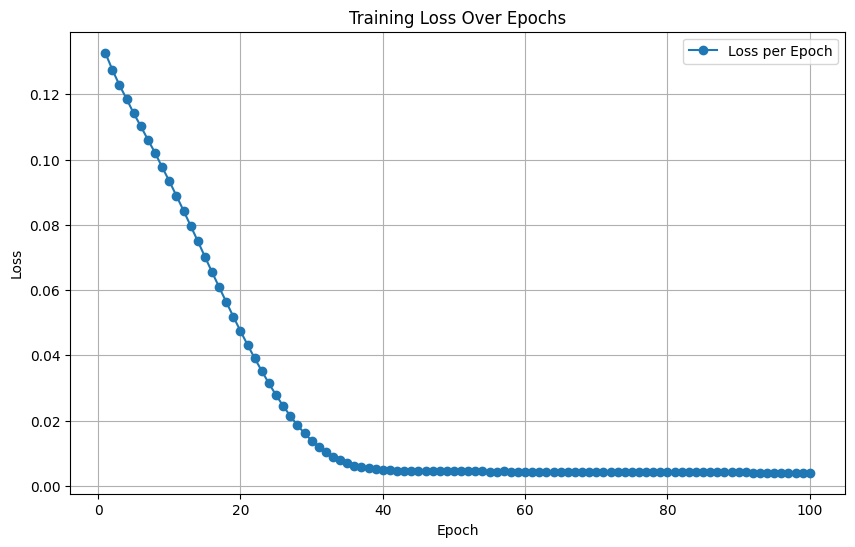

In [34]:
import matplotlib.pyplot as plt

# Initialize the model, loss function, and optimizer
model = RankingNN(female_input_dim=females_features.shape[1], male_input_dim=males_features.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 100
losses = []  # Для хранения значений loss

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0  # Сумма потерь за эпоху

    for batch in data_loader:
        optimizer.zero_grad()

        female_features = batch['female']
        male_features = batch['male']
        edge_weights = batch['weight']

        predictions = model(female_features, male_features)
        loss = criterion(predictions.squeeze(), edge_weights)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # Добавляем потери за батч

        if loss.item() <= 0.001:  # Прерываем обучение, если достигли достаточно малого loss
            break

    avg_loss = epoch_loss / len(data_loader)  # Среднее значение потерь за эпоху
    losses.append(avg_loss)  # Сохраняем для графика

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Построение графика loss-функции
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o', label='Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# The model is now trained and you can use it to predict rankings for new females


In [23]:
torch.save(model.state_dict(), 'zero_loss.pth')

In [24]:
from catboost import CatBoostRanker, Pool
import numpy as np

# Формирование данных для CatBoost
X = []  # Матрица признаков
y = []  # Целевые значения (вес ребра)
group_id = []  # Группы для list-wise ранжирования

current_group = 0
group_size = 5  # Длина каждого списка для ранжирования

for i in range(0, len(edge_weights_all), group_size):
    group_female_features = female_features_all[i:i + group_size]
    group_male_features = male_features_all[i:i + group_size]
    group_weights = edge_weights_all[i:i + group_size]

    # Если данных меньше, чем group_size, пропускаем
    if len(group_weights) < group_size:
        continue

    # Формируем признаки для каждой пары (женщина, мужчина)
    for female, male, weight in zip(group_female_features, group_male_features, group_weights):
        X.append(np.concatenate([female, male]))  # Объединяем признаки женщины и мужчины
        y.append(weight)
        group_id.append(current_group)

    current_group += 1

X = np.array(X)
y = np.array(y)

# Разделение на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, group_id_train, group_id_test = train_test_split(
    X, y, group_id, test_size=0.2, random_state=42
)


In [28]:
# Создание объекта CatBoostRanker
ranker = CatBoostRanker(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='YetiRank',
    verbose=50
)

# Преобразуем данные в numpy для сортировки
X_train = np.array(X_train)
y_train = np.array(y_train)
group_id_train = np.array(group_id_train)

# Сортировка данных по group_id
sorted_indices = np.argsort(group_id_train)
X_train = X_train[sorted_indices]
y_train = y_train[sorted_indices]
group_id_train = group_id_train[sorted_indices]

# Теперь создаем Pool
train_pool = Pool(data=X_train, label=y_train, group_id=group_id_train)
# Преобразуем данные в numpy для сортировки
X_test = np.array(X_test)
y_test = np.array(y_test)
group_id_test = np.array(group_id_test)

# Сортировка данных по group_id_test
sorted_indices_test = np.argsort(group_id_test)
X_test = X_test[sorted_indices_test]
y_test = y_test[sorted_indices_test]
group_id_test = group_id_test[sorted_indices_test]

# Создаем test_pool
test_pool = Pool(data=X_test, label=y_test, group_id=group_id_test)


# Обучение модели
ranker.fit(train_pool, eval_set=test_pool)


0:	test: 0.3094669	best: 0.3094669 (0)	total: 155ms	remaining: 1m 17s
50:	test: 0.3115031	best: 0.3115486 (33)	total: 242ms	remaining: 2.13s
100:	test: 0.3114789	best: 0.3115673 (84)	total: 326ms	remaining: 1.29s
150:	test: 0.3111481	best: 0.3115673 (84)	total: 411ms	remaining: 950ms
200:	test: 0.3110649	best: 0.3115673 (84)	total: 495ms	remaining: 737ms
250:	test: 0.3110649	best: 0.3115673 (84)	total: 580ms	remaining: 576ms
300:	test: 0.3111481	best: 0.3115673 (84)	total: 665ms	remaining: 440ms
350:	test: 0.3111481	best: 0.3115673 (84)	total: 750ms	remaining: 318ms
400:	test: 0.3110649	best: 0.3115673 (84)	total: 833ms	remaining: 206ms
450:	test: 0.3110649	best: 0.3115673 (84)	total: 921ms	remaining: 100ms
499:	test: 0.3110649	best: 0.3115673 (84)	total: 1s	remaining: 0us

bestTest = 0.3115672893
bestIteration = 84

Shrink model to first 85 iterations.


In [35]:
class ListWiseRankingNN(nn.Module):
    def __init__(self, female_input_dim, male_input_dim):
        super(ListWiseRankingNN, self).__init__()
        self.fc1 = nn.Linear(female_input_dim + male_input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Score for each pair

    def forward(self, female_features, male_features):
        # Concatenate features for females and males
        x = torch.cat([female_features, male_features], dim=2)  # Note dim=2 for list-wise
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output scores for the list
        return x.squeeze(-1)  # Output shape: (batch_size, list_size)


In [36]:
class ListWiseRankingDataset(Dataset):
    def __init__(self, female_features, male_features, edge_weights, group_size=5):
        self.group_size = group_size

        # Преобразуем данные в list-wise формат
        self.female_features, self.male_features, self.edge_weights = [], [], []

        for i in range(0, len(edge_weights), group_size):
            if i + group_size <= len(edge_weights):  # Убедимся, что группы полные
                self.female_features.append(female_features[i:i + group_size])
                self.male_features.append(male_features[i:i + group_size])
                self.edge_weights.append(edge_weights[i:i + group_size])

    def __len__(self):
        return len(self.edge_weights)

    def __getitem__(self, idx):
        return {
            'female': torch.tensor(self.female_features[idx], dtype=torch.float32),
            'male': torch.tensor(self.male_features[idx], dtype=torch.float32),
            'weight': torch.tensor(self.edge_weights[idx], dtype=torch.float32),
        }

# Обновим датасет
group_size = 5
dataset = ListWiseRankingDataset(female_features_all, male_features_all, edge_weights_all, group_size)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [37]:
def yetirank_loss(predictions, targets):
    # Calculate pairwise differences
    delta = predictions.unsqueeze(1) - predictions.unsqueeze(2)  # Pairwise differences
    true_diff = (targets.unsqueeze(1) - targets.unsqueeze(2)).sign()  # True rank order

    # Exponential pairwise loss
    loss_matrix = torch.exp(-delta * true_diff)  # Exponentially penalize wrong orders
    return loss_matrix.mean()


Epoch 1/120, Loss: 0.9984
Epoch 2/120, Loss: 0.9961
Epoch 3/120, Loss: 0.9914
Epoch 4/120, Loss: 0.9899
Epoch 5/120, Loss: 0.9835
Epoch 6/120, Loss: 0.9727
Epoch 7/120, Loss: 0.9686
Epoch 8/120, Loss: 0.9627
Epoch 9/120, Loss: 0.9506
Epoch 10/120, Loss: 0.9409
Epoch 11/120, Loss: 0.9198
Epoch 12/120, Loss: 0.9237
Epoch 13/120, Loss: 0.9412
Epoch 14/120, Loss: 0.9017
Epoch 15/120, Loss: 0.8864
Epoch 16/120, Loss: 0.8992
Epoch 17/120, Loss: 0.8509
Epoch 18/120, Loss: 0.8692
Epoch 19/120, Loss: 0.8767
Epoch 20/120, Loss: 0.8308
Epoch 21/120, Loss: 0.8268
Epoch 22/120, Loss: 0.8248
Epoch 23/120, Loss: 0.8004
Epoch 24/120, Loss: 0.7903
Epoch 25/120, Loss: 0.7643
Epoch 26/120, Loss: 0.7636
Epoch 27/120, Loss: 0.7306
Epoch 28/120, Loss: 0.7310
Epoch 29/120, Loss: 0.7055
Epoch 30/120, Loss: 0.6795
Epoch 31/120, Loss: 0.6685
Epoch 32/120, Loss: 0.6464
Epoch 33/120, Loss: 0.6347
Epoch 34/120, Loss: 0.6409
Epoch 35/120, Loss: 0.6278
Epoch 36/120, Loss: 0.5857
Epoch 37/120, Loss: 0.5596
Epoch 38/1

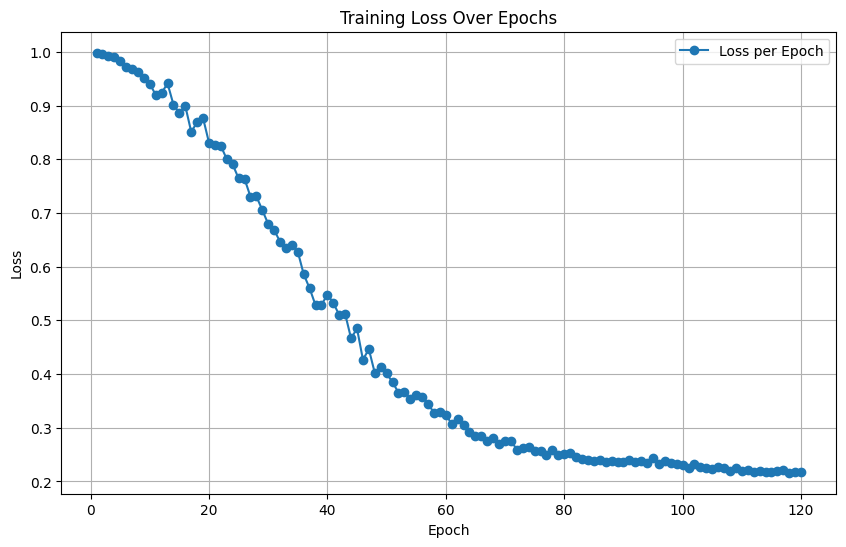

In [40]:
# Initialize the model, optimizer
model = ListWiseRankingNN(female_input_dim=females_features.shape[1], male_input_dim=males_features.shape[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Training loop
num_epochs = 120
losses = []  # To store loss values for plotting

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch in data_loader:
        optimizer.zero_grad()

        female_features = batch['female']  # Shape: (batch_size, group_size, feature_dim)
        male_features = batch['male']      # Shape: (batch_size, group_size, feature_dim)
        edge_weights = batch['weight']    # Shape: (batch_size, group_size)

        predictions = model(female_features, male_features)  # Shape: (batch_size, group_size)
        loss = yetirank_loss(predictions, edge_weights)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(data_loader)
    losses.append(avg_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o', label='Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Строить прогнозы как-то так:

# Преобразуем данные в тензоры
female_features_tensor = torch.tensor(new_female_features, dtype=torch.float32).unsqueeze(0)  # (1, 5, feature_dim)
male_features_tensor = torch.tensor(new_male_features, dtype=torch.float32).unsqueeze(0)    # (1, 5, feature_dim)

# Получаем предсказания от модели
model.eval()  # Устанавливаем модель в режим предсказания
with torch.no_grad():  # Отключаем вычисление градиентов для ускорения
    predictions = model(female_features_tensor, male_features_tensor)  # (1, 5)

# Интерпретируем результаты
predicted_ranks = predictions.squeeze().numpy()  # Получаем скоры для каждой пары (размер: 5)

# Сортируем индексы предсказанных результатов, чтобы отсортировать по рангу
sorted_indices = predicted_ranks.argsort()  # Сортировка индексов в порядке возрастания (или убывания, зависит от задачи)

# Получаем отсортированные данные
sorted_female_features = [new_female_features[i] for i in sorted_indices]
sorted_male_features = [new_male_features[i] for i in sorted_indices]

# Выводим результаты
print("Predicted ranks for the group:")
for idx, (female, male) in enumerate(zip(sorted_female_features, sorted_male_features)):
    print(f"Rank {idx+1}: Female {female} <-> Male {male}, Predicted Score: {predicted_ranks[sorted_indices[idx]]:.4f}")

## Make predictions!

In [12]:
# Get the model's predictions for the new female
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = []
    for batch in data_loader:
        female_features = batch['female']
        male_features = batch['male']
        
        # Get predicted rankings (scores)
        predicted_scores = model(female_features, male_features).squeeze().numpy()
        predictions.extend(predicted_scores)

In [13]:
predictions_indexed = [(x, i) for i, x in enumerate(predictions)]
predictions_indexed.sort(key=lambda x: -x[0])

In [14]:
best_match = predictions_indexed[0][1]
print("The best match ID is:", best_match)

The best match ID is: 181


In [15]:
essays_male = [male_data.iloc[best_match][f"essay{i}"] for i in range(10)]
essays_female = [female_data.iloc[female_idx][f"essay{i}"] for i in range(10)]

print("MALE ESSAYS:")
for e in essays_male:
    if e is not np.nan:
        print(e)
print("=================================")
print("FEMALE ESSAYS:")
for e in essays_female:
    if e is not np.nan:
        print(e)

MALE ESSAYS:
i'm very honest & straightforward, both with you & with me, so i tend to know what i'm about and i don't mind telling you how i'm feeling. i like people who are communicative & functional - i don't want to have to guess what's wrong, i want you to tell me, and if you're happy i'd like to hear about it. i'm easy to get along with, probably largely because i'm not very demanding and i am very forgiving - i'm appreciative of the things that work out between us and i understand that sometimes things just don't quite go as planned. so you're late, or you have to cancel something, or you're grumpy in the mornings - so what? i take everyone with a grain of salt, and i don't tend to take anything too seriously.  i like to see people i care about as often as i can, but whether that translates to once a month or twice a week is fine. some people are busy, some aren't - live your life how you want to, and i'll be happy if we can do so together. i might really love spending time with 